In [10]:
import time
import numpy
import urllib
import scipy.optimize
import random
from collections import defaultdict
from collections import Counter
import string
from sklearn import linear_model
import ast
import importlib
import numpy as np
from scipy.spatial import distance
import random
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from nltk.corpus import stopwords
import sklearn

nltk.download("averaged_perceptron_tagger")
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Charlie/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Charlie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
import as2_analysis_utils as as2_analysis
import as2_plot_utils as as2_plot
importlib.reload(as2_analysis)
importlib.reload(as2_plot)

<module 'as2_plot_utils' from '/Users/Charlie/Documents/Work_School/UCSD/Grad/Fall_2020/CSE258/assignment2/as2_plot_utils.py'>

In [12]:
data_all = list(as2_analysis.parseData_line("renttherunway_final_data.json"))

In [13]:
def extract_features(data_all, key):
    """
    return data of particualr key
    """
    return [d[key] for d in data_all]

In [14]:
stop_words = [word for word in stopwords.words("english") 
              if word != "not" and 
              not ("n'" in word)]

 # Count word frequency

In [15]:
# top words in fit reviews
fit_reviews_all = [
    d["review_text"] + " " + d["review_summary"] for d in data_all if d["fit"] == "fit"
]
small_reviews_all = [
    d["review_text"] + " " + d["review_summary"]
    for d in data_all
    if d["fit"] == "small"
]
large_reviews_all = [
    d["review_text"] + " " + d["review_summary"]
    for d in data_all
    if d["fit"] == "large"
]



In [16]:
resample_size = np.mean([len(small_reviews_all),len(large_reviews_all)])

In [17]:
fit_reviews_all_resample = random.sample(fit_reviews_all,int(resample_size))

In [18]:
def tokenize_data_sets(dataset, n=1):
    """
    Each item of dataset is a str
    """
    return [as2_analysis.tokenize_paragraph(d, n=n,remove_stopwrods=True,stopwords=stop_words) for d in dataset]



In [41]:
# tokenize dataset
fit_tokenized_all = tokenize_data_sets(fit_reviews_all_resample,n=1)
small_tokenized_all = tokenize_data_sets(small_reviews_all,n=1)
large_tokenized_all = tokenize_data_sets(large_reviews_all,n=1)



In [42]:
fit_word_count = as2_analysis.count_word_freq(fit_tokenized_all)
small_word_count = as2_analysis.count_word_freq(small_tokenized_all)
large_word_count = as2_analysis.count_word_freq(large_tokenized_all)


 # Get most frequent adjective

In [43]:
def get_adj(word_list):
    """
    return adj from a list of words 
    """
    word_list_adj = []
    
    for word in word_list:
        if isinstance(word,str) and nltk.pos_tag([word])[0][1][0] == "J":
            word_list_adj.append(word)
    
    return word_list_adj

In [44]:
def top_n_adj(word_count_dict):
    """
    only works for unigram
    """
    adj_list = get_adj(word_count_dict.keys())
    adj_count = {adj : word_count_dict[adj] for adj in adj_list}
    
    # sort them into pairs
    adj_count_pair = [(count, key) for key, count in adj_count.items()]

    # sort
    adj_count_pair.sort(reverse=True)

    return adj_count_pair

In [45]:
start = time.time()
top_small_adj = top_n_adj(small_word_count)
top_fit_adj = top_n_adj(fit_word_count)
top_big_adj = top_n_adj(large_word_count)


end = time.time()
print(f"time consume: {end-start}s")

time consume: 9.211933851242065s


 Try bigram and trigram

In [24]:
def top_n_adj_n_gram(word_count_dict):

    ## get the most common ajectives
    adj_count = {
        key: word_count_dict[key]
        for key in word_count_dict
        # if either of the word is an adj, preserve
        if any(
            wordType[0] == "J"
            for _, wordType in nltk.pos_tag(key if type(key) == tuple else (key,))
        )
    }

    # sort them into pairs
    adj_count_pair = list(adj_count.items())

    # # sort
    adj_count_pair.sort(reverse=True, key=lambda x: x[1])

    return adj_count_pair



In [25]:
def top_adj_pipeline(fit_word_count, small_word_count, large_word_count):

    start = time.time()
    top_fit_grams = top_n_adj_n_gram(fit_word_count)
    top_small_grams = top_n_adj_n_gram(small_word_count)
    top_large_grams = top_n_adj_n_gram(large_word_count)
    end = time.time()
    print(f"time consume: {end-start}s")
    return top_fit_grams, top_small_grams, top_large_grams



In [26]:
top_fit_grams, top_small_grams, top_large_grams = top_adj_pipeline(fit_word_count,
                                                                   small_word_count,
                                                                   large_word_count)

time consume: 223.83546805381775s


In [27]:
bigrams_common = as2_analysis.count_word_freq(fit_tokenized_all + small_tokenized_all + large_tokenized_all)

In [28]:
def intersection_fit_small_large(fit_top, small_top, large_top, world_count_all,index=0):
    """
    Find the intersection between top ngrams from each set
    """
    fit_ngram = [item[index] for item in fit_top]
    small_ngram = [item[index] for item in small_top]
    large_ngram = [item[index] for item in large_top]
    
    intersection = set.intersection(set(fit_ngram),set(small_ngram),set(large_ngram))
    return_tuple = [(world_count_all[item],item) for item in intersection]
    return_tuple.sort(reverse=True)
#     return return_tuple.sort(reverse=True)
    return fit_ngram, small_ngram, large_ngram, return_tuple

In [29]:
fit_ngram, small_ngram, large_ngram,top_common_ngram = intersection_fit_small_large(top_fit_grams[:300], 
                                                top_small_grams[:300], 
                                                top_large_grams[:300], 
                                                bigrams_common,
                                                0)

In [30]:
def generate_gram_id(fit_ngram):
    n_grams = len(fit_ngram)
    return dict(zip(fit_ngram, range(n_grams)))

In [31]:
fit_gramID = generate_gram_id(fit_ngram)
small_gramID = generate_gram_id(small_ngram)
large_gramID = generate_gram_id(large_ngram)

In [32]:
def generate_top_unigrams(top_unigram_pair,index=1,top_n=500):
    top_grams = [item[index] for item in top_unigram_pair[:top_n]]
    top_grams_id = dict(zip(top_grams,range(len(top_grams))))
    
    return top_grams, top_grams_id

In [46]:
top_fit_unit, top_fit_uniID = generate_top_unigrams(top_fit_adj,index=1,top_n=300)
top_small_unit, top_small_uniID = generate_top_unigrams(top_small_adj,index=1,top_n=300)
top_large_unit, top_large_uniID = generate_top_unigrams(top_big_adj,index=1,top_n=300)

In [47]:
top_fit_unit

['great',
 'comfortable',
 'little',
 'many',
 'true',
 'short',
 'black',
 'gorgeous',
 'much',
 'nice',
 'overall',
 'small',
 'easy',
 'good',
 'big',
 'formal',
 'able',
 'regular',
 'high',
 'large',
 'low',
 'loose',
 'best',
 'heavy',
 'different',
 'red',
 'larger',
 'smaller',
 'casual',
 'worried',
 'white',
 'classic',
 'ive',
 'hot',
 'happy',
 'extra',
 'hard',
 'open',
 'full',
 'uncomfortable',
 'normal',
 'conservative',
 'available',
 'new',
 'fabulous',
 'due',
 'next',
 'bigger',
 'soft',
 'difficult',
 'fantastic',
 'chic',
 'special',
 'second',
 'glamorous',
 'bad',
 'several',
 'last',
 'nervous',
 'noticeable',
 'whole',
 'sophisticated',
 'flat',
 'lower',
 'tiny',
 'huge',
 'wide',
 'unlimited',
 'professional',
 'adorable',
 'original',
 'entire',
 'athletic',
 'green',
 'higher',
 'usual',
 'surprised',
 'old',
 'modest',
 'concerned',
 'incredible',
 'pleased',
 'real',
 'broad',
 'wrong',
 'least',
 'optional',
 'upper',
 'rich',
 'natural',
 'disappointed

 # Data Prediction

## Get data

In [49]:
data_fit = [d for d in data_all if d["fit"]=="fit"]
data_small = [d for d in data_all if d["fit"]=="small"]
data_large = [d for d in data_all if d["fit"]=="large"]

In [50]:
data_balance = data_small + data_large + random.sample(data_fit,int(resample_size))

In [51]:
random.shuffle(data_balance)

In [52]:
data_size = len(data_balance)
valid_percent = 0.2
test_percent = 0.2


In [53]:
data_train = data_balance[: int(data_size * (1 - valid_percent - test_percent))]
data_valid = data_balance[
    int(data_size * (1 - valid_percent - test_percent)) : int(
        data_size * (1 - test_percent)
    )
]
data_test = data_balance[int(data_size * (1 - test_percent)) :]

##  Try n-gram BoW logistic regression

In [54]:
len(top_fit_gram_freq)

NameError: name 'top_fit_gram_freq' is not defined

In [55]:
def feature_per_category(p_list, ngram_set, ngram_ID):
    feat = np.zeros(len(ngram_ID))
    
    for word in p_list:
        if word in ngram_set:
#             df = p_list.count(word)
#             feat[ngram_ID[word]] = df * top_gram_freq[word]
            feat[ngram_ID[word]] += 1
#     print(feat.shape)
    return feat

In [56]:
def feature_ngram(d,n, fitID, smallID, largeID):
    """
    create features using bigram
    """
    review = d["review_text"] + " " + d["review_summary"]
    p_list = as2_analysis.tokenize_paragraph(review, n=n,remove_stopwrods=True,stopwords=stop_words)
    
    # get features for fit
    fit_set = set(fitID.keys()) 
    feat_fit = feature_per_category(p_list,fit_set,fitID)
    
    # get features for small
    small_set = set(smallID.keys())
    feat_small = feature_per_category(p_list,small_set, smallID)
       
    # get feature for large
    large_set = set(largeID.keys())
    feat_large = feature_per_category(p_list,large_set,largeID)
    
    return np.concatenate((feat_fit,feat_small,feat_large))


In [57]:
def encode_output(data):
    return [0 if d["fit"] == "fit" else 1 if d["fit"] == "small" else 2 for d in data]

In [58]:
FIT = 0
SMALL = 1
BIG = 2
X_train = [np.append(feature_ngram(d, 2, fit_gramID, small_gramID, large_gramID),
                     feature_ngram(d, 1, top_fit_uniID, top_small_uniID, top_large_uniID))
                     for d in data_train]                     
y_train = encode_output(data_train)

# validation data
X_valid = [np.append(feature_ngram(d, 2, fit_gramID, small_gramID, large_gramID),
                     feature_ngram(d, 1, top_fit_uniID, top_small_uniID, top_large_uniID))
                     for d in data_valid]
y_valid = encode_output(data_valid)


In [63]:
from sklearn.decomposition import TruncatedSVD

In [64]:
svd = TruncatedSVD(n_components=500)
x_train_new = svd.fit_transform(X_train)
x_val_new = svd.transform(X_valid)

In [65]:
from sklearn.svm import LinearSVC
svc = LinearSVC(C=0.01)
svc.fit(x_train_new, y_train)
y_pred_svc = svc.predict(x_val_new)

In [66]:
from sklearn.naive_bayes import MultinomialNB

In [67]:
model_nb = MultinomialNB()
model_nb.fit(X_train,y_train)
y_pred_nb = model_nb.predict(X_valid)

In [74]:
model = linear_model.LogisticRegression(C=3)

In [69]:
model.fit(x_train_new, y_train)
y_pred = model.predict(x_val_new)

/Users/Charlie/opt/anaconda3/envs/cse258/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [75]:
# use OrdinalClassifier
ordianl = as2_analysis.OrdinalClassifier(model)
ordianl.fit(x_train_new, y_train)
y_val_pred_ordianl = ordianl.predict(x_val_new)

/Users/Charlie/opt/anaconda3/envs/cse258/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/Charlie/opt/anaconda3/envs/cse258/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

In [81]:
val_cm = as2_analysis.compute_confusion_matrix(y_valid,y_pred,normalized=True)

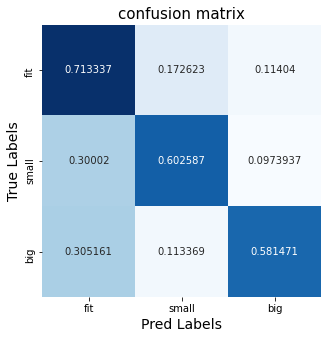

In [82]:
as2_plot.plot_cm(val_cm, ["fit","small","big"])

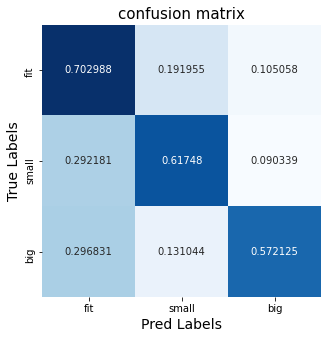

In [78]:
as2_plot.plot_cm(val_cm, ["fit","small","big"])